In [1]:
import nltk
from collections import Counter
from itertools import combinations
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix
)
from gensim.models import Word2Vec
from IPython.display import display_html
import networkx as nx
from helper_func import compute_metrics,clean_text, WeightedLossTrainer, analyze_connectivity,compute_metrics,\
    build_graph,draw_graph,compute_cliques, generate_report,model_metrics, evaluate_model,display_side_by_side

import seaborn as sns
from wordcloud import WordCloud
import igraph as ig
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification,TrainingArguments,Trainer, RobertaForSequenceClassification,RobertaTokenizerFast
from sklearn.utils.class_weight import compute_class_weight
import torch
from datasets import Dataset
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from collections import defaultdict



/home/lewris/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Introduction

This project examines how language is structured within the **Kaggle News Category Dataset** and how these linguistic patterns support **supervised text classification**. The dataset contains approximately **200,000 news articles** published between **2012 and 2022** across **41 categories**, making it well suited for analyzing **topic structure**, **vocabulary overlap**, and the challenges of distinguishing closely related news domains.

The analysis begins with the construction of a **sentence-level word co-occurrence network** to explore how terms are shared across articles and categories. This network highlights **clusters of related vocabulary**, identifies words that act as **bridges between topics**, and provides an initial structural view of how language is organized within the dataset. These patterns offer insight into which categories are **linguistically distinct** and which exhibit substantial overlap.

Building on this structural analysis, multiple **supervised classification models** are trained to predict article categories from text. Traditional machine learning models, including **Logistic Regression**, **Support Vector Machines (SVM)**, and **Random Forests**, are trained using vectorized text representations such as **TF-IDF** and **Word2Vec-based document embeddings**. In parallel, a **transformer-based DistilBERT model** is fine-tuned directly on the raw text to capture contextual and semantic information beyond fixed feature representations. Comparing model performance across these approaches helps assess how different text representations and model capacities interact with the linguistic structure revealed by the co-occurrence network. Together, this combined analysis provides insight into both the internal organization of the dataset and the practical limits of automated news classification.


## 2. Overview

The analysis uses the **Kaggle News Category Dataset**, which contains news articles published over a ten-year period along with associated metadata. Each record represents a single article and includes the following fields:

- **link**: URL to the original article  
- **headline**: Article headline  
- **short_description**: Brief summary of the article content  
- **category**: News category label used as the target variable  
- **authors**: Author information  
- **date**: Publication date  

In this project, both the **headline** and **short_description** fields are used as textual inputs for network analysis and supervised classification, while **category** serves as the response variable. The remaining fields are retained for contextual reference but are not directly used in model training.


In [2]:
news_df = pd.read_json("news_category.json",lines=True)
news_df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


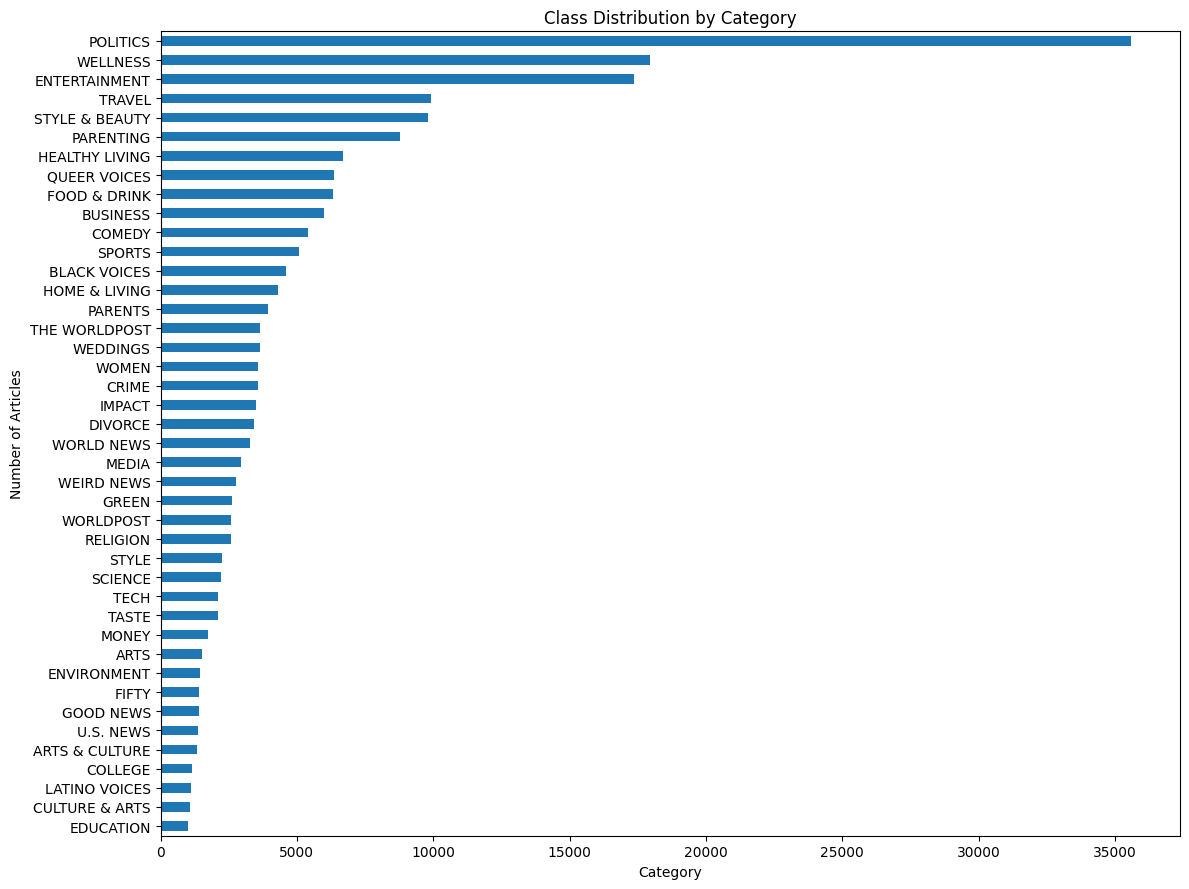

In [3]:

counts = news_df["category"].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 9))
counts.plot(kind="barh", ax=ax)

ax.set_title("Class Distribution by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Number of Articles")
# ax.tick_params(axis="x", rotation=45)


fig.tight_layout()


The plot below shows the distribution of articles across news categories, which is the only feature for which the class distribution can be directly visualized at this stage. It highlights substantial class imbalance in the dataset, with a small number of categories accounting for a large share of the articles while many others are sparsely represented.

The categories containing most of the articles. **POLITICS** has by far the largest number of articles, followed by **WELLNESS** and **ENTERTAINMENT**, while many other categories appear much less often. Looking more closely at the labels, it also becomes clear that several categories overlap in topic or even describe the same type of content, such as **ARTS & CULTURE** and **CULTURE & ARTS**. This combination of class imbalance and overlapping categories makes the classification task more difficult and motivates the decision to merge similar categories before modeling.

## 2. Data Preparation

The data preparation process starts by **combining each article’s headline and short description into a single text field**. This provides more context per document and serves as the base input for all subsequent steps.

- Original category labels are reviewed, and **some categories are merged into broader groups** based on semantic similarity in order to **reduce label redundancy and mitigate class imbalance**.
- The cleaned text is processed using a lightweight spaCy pipeline that performs **sentence segmentation** and **lemmatization**, while removing **stopwords**, **non-alphabetic tokens**, and very **short terms** to standardize the vocabulary.
- Using the processed text, word frequencies and sentence-level word co-occurrence counts are computed separately for each merged category to enable category-specific analysis.
- Global word frequencies and category dispersion are calculated to identify terms that are too rare, overly frequent, or widely shared across categories, and these low-information terms are filtered out.
- Cleaned, category-specific word frequency and co-occurrence datasets are constructed and used as the foundation for network construction and subsequent analysis.




In [4]:

news_df["text"] = news_df["headline"] + " " + news_df["short_description"]
news_df["clean_text"] = news_df["text"].apply(clean_text)

merge_map = {
    # 'U.S. NEWS': 'POLITICS',
    # 'POLITICS': 'POLITICS',
    'WORLD NEWS': 'WORLD',
    'THE WORLDPOST': 'WORLD',
    'WORLDPOST': 'WORLD',

    'BUSINESS': 'BUSINESS',
    'MONEY': 'BUSINESS',

    'ENTERTAINMENT': 'ENTERTAINMENT',
    'COMEDY': 'ENTERTAINMENT',
    'MEDIA': 'ENTERTAINMENT',
    'WEIRD NEWS': 'ENTERTAINMENT',
    
    'ARTS': 'ARTS & CULTURE',
    'ARTS & CULTURE': 'ARTS & CULTURE',
    'CULTURE & ARTS': 'ARTS & CULTURE',
    

    'TECH': 'SCIENCE & TECH',
    'SCIENCE': 'SCIENCE & TECH',

    'HEALTHY LIVING': 'WELLNESS',

    'HOME & LIVING': 'LIFESTYLE',
    'WEDDINGS': 'LIFESTYLE',
    'GOOD NEWS': 'LIFESTYLE',
    'FIFTY': 'LIFESTYLE',
    'IMPACT': 'LIFESTYLE',

    'PARENTING': 'PARENTING',
    'PARENTS': 'PARENTING',
    'DIVORCE': 'PARENTING',

    'STYLE': 'STYLE',
    'STYLE & BEAUTY': 'STYLE',
    'TRAVEL': 'STYLE',

    'FOOD & DRINK': 'FOOD',
    'TASTE': 'FOOD',

    'ENVIRONMENT': 'ENVIRONMENT',
    'GREEN': 'ENVIRONMENT',

    'WOMEN': 'IDENTITY',
    'BLACK VOICES': 'IDENTITY',
    'LATINO VOICES': 'IDENTITY',
    'QUEER VOICES': 'IDENTITY',

    'EDUCATION': 'EDUCATION',
    'COLLEGE': 'EDUCATION'
}

news_df["category_merged"] = news_df["category"].replace(merge_map)

In [5]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  
nlp.add_pipe("sentencizer") 



In [6]:
texts = news_df["short_description"].fillna("")
cats  = news_df["category_merged"]  

pair_freq_by_cat = defaultdict(Counter)
word_freq_by_cat = defaultdict(Counter)

for text, cat in tqdm(zip(texts, cats), total=len(news_df), desc="Processing documents"):
    doc = nlp(text.lower())

    for sent in doc.sents:
        tokens = [
            tok.lemma_ for tok in sent
            if tok.is_alpha
            and not tok.is_stop
            and len(tok) > 2
        ]

        if len(tokens) < 2:
            continue

        uniq = list(set(tokens))

        word_freq_by_cat[cat].update(uniq)

        for w1, w2 in combinations(uniq, 2):
            pair = tuple(sorted((w1, w2)))
            pair_freq_by_cat[cat][pair] += 1



Processing documents: 100%|██████████| 209527/209527 [04:46<00:00, 730.68it/s] 


In [7]:

global_word_freq = Counter()
category_dispersion = Counter()

for cat, counter in word_freq_by_cat.items():
    global_word_freq.update(counter)

    for word in counter:
        category_dispersion[word] += 1


In [8]:
      
freq_values = np.array(list(global_word_freq.values()))

min_freq = 5                               
max_freq = np.percentile(freq_values, 98)  

num_categories = len(word_freq_by_cat)
max_categories = int(0.6 * num_categories) 

valid_words = {
    w for w, f in global_word_freq.items()
    if min_freq <= f <= max_freq
    and category_dispersion[w] <= max_categories
}

In [9]:
clean_word_freq_by_cat = defaultdict(Counter)

for cat, counter in word_freq_by_cat.items():
    for word, freq in counter.items():
        if word in valid_words:
            clean_word_freq_by_cat[cat][word] = freq

In [10]:
global_word_freq_all_cat = Counter()

for cat,freq_data in clean_word_freq_by_cat.items():
    global_word_freq_all_cat.update(freq_data)


In [11]:
clean_pair_freq_by_cat = defaultdict(Counter)

for cat, pair_counter in pair_freq_by_cat.items():
    for (w1, w2), freq in pair_counter.items():
        if w1 in valid_words and w2 in valid_words:
            clean_pair_freq_by_cat[cat][(w1, w2)] = freq
            
            

# 3. Co-Ocurrence Networks

This section introduces the use of word co-occurrence networks to explore how language is structured within the news corpus. Rather than focusing on individual words in isolation, this approach allows us to examine how words appear together within local contexts.

As a first step, we visualize the global word frequencies across all categories to provide a high-level overview of the vocabulary present in the dataset. This representation offers a compact summary of commonly used terms and helps contextualize the language that will appear in the network analyses that follow. A single co-occurrence network built across all categories would be too large and dense to interpret effectively, so this global view is used as an initial point of reference.


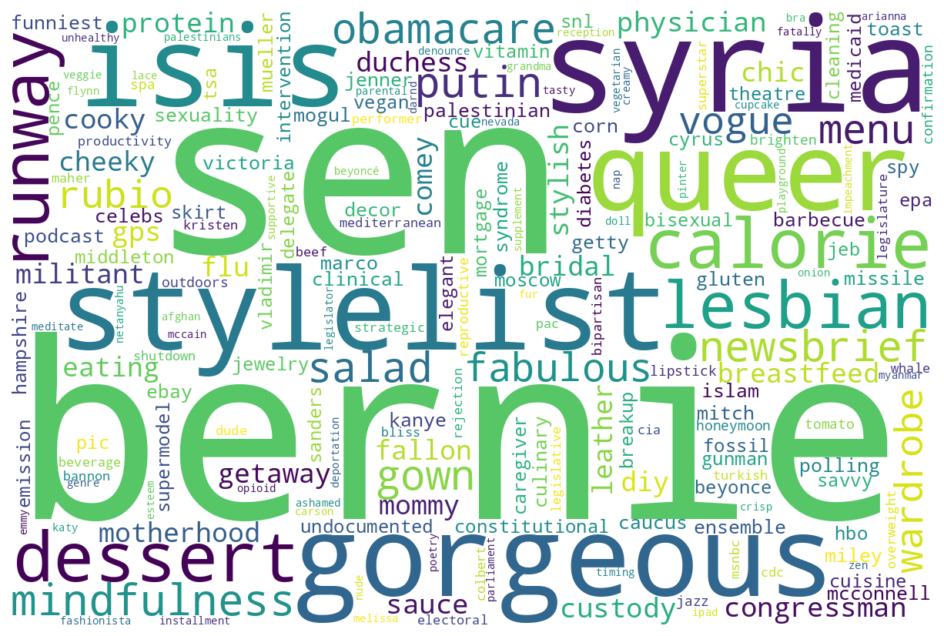

In [12]:
plt.subplots(figsize=(14, 8))

wc = WordCloud(width=1200, height=800, background_color="white")
wc.generate_from_frequencies(global_word_freq_all_cat)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

The global word frequency plot shows which terms appear most often across the entire corpus, without considering how words relate to each other. The most prominent words reflect broad and recurring themes in the dataset, including **politics**, **style** and **fashion**, **food** and **lifestyle**, **identity-related topics**, and **science and technology**. The presence of terms associated with public figures, cultural topics, and everyday lifestyle concepts indicates that the corpus mixes hard news with opinion, entertainment, and personal-interest content.

In [13]:
category_networks = {}


for cat in news_df["category_merged"].unique():
    G =  build_graph(cat,clean_pair_freq_by_cat)
    largest_cc = max(nx.connected_components(G),key=len)
    SG = G.subgraph(largest_cc).copy()
    
    figure, axis = draw_graph(SG,f"{cat} Co-Ocurrence Network")
    arts_metadata = compute_metrics(SG,10, f"{cat} Metrics")
    category_networks[cat] = {"nxGraph":SG,"nxPlot":figure,"metrics":arts_metadata}



Building on this overview, we then construct and analyze category-specific co-occurrence networks on three topics of my interest (**ARTS & CULTURE**, **SCIENCE & TECH**, and **POLITICS**). 

### 3.1 Arts & Culture

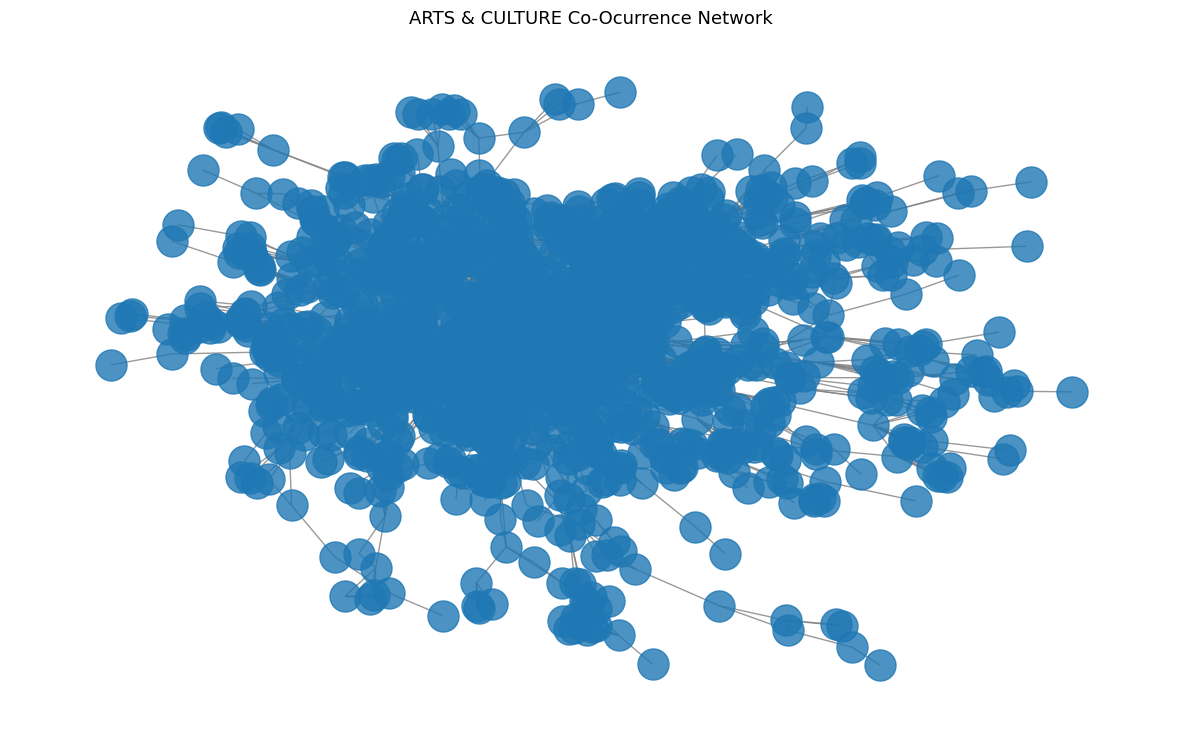

In [14]:
category_networks["ARTS & CULTURE"]["nxPlot"]

In [15]:
arts_metadata = compute_metrics(category_networks["ARTS & CULTURE"]["nxGraph"],10, f"Arts & Culture Category")
display_html(arts_metadata["metrics_view"], raw=True)

Arts & Culture Category Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.575420 
 
 
 Weighted Average Clustering 
 0.059076 
 
 
 Density 
 0.003059 
 
 
 

 
 
 Degree Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 theatre 
 0.052950 
 1.308411 
 
 
 1 
 ballet 
 0.043116 
 1.065421 
 
 
 2 
 painter 
 0.027231 
 0.672897 
 
 
 3 
 poetry 
 0.024962 
 0.616822 
 
 
 4 
 playwright 
 0.024206 
 0.598131 
 
 
 5 
 canvas 
 0.021936 
 0.542056 
 
 
 6 
 shakespeare 
 0.018911 
 0.467290 
 
 
 7 
 artwork 
 0.018911 
 0.467290 
 
 
 8 
 sculpture 
 0.018154 
 0.448598 
 
 
 9 
 drawing 
 0.017398 
 0.429907 
 
 
 
 
 
 Betweenness Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 theatre 
 0.305751 
 6.217118 
 
 
 1 
 ballet 
 0.200275 
 4.072380 
 
 
 2 
 poetry 
 0.139370 
 2.833934 
 
 
 3 
 painter 
 0.127902 
 2.600741 
 
 
 4 
 shakespeare 
 0.101139 
 2.056553 
 
 
 5 
 playwright 
 0.096096 
 1.953998 
 
 
 6 
 eccentric 
 0.086711 
 1.763167 
 
 
 7 
 canvas 
 0.084883 
 1.726005 
 
 
 8 
 jazz 
 0.072191 
 1.467924 
 
 
 9 
 compose 
 0.071196 
 1.447687 
 
 
 
 
 
 Eigenvector Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 theatre 
 0.514668 
 3.781086 
 
 
 1 
 ballet 
 0.290047 
 2.130872 
 
 
 2 
 playwright 
 0.179671 
 1.319980 
 
 
 3 
 playhouse 
 0.172842 
 1.269812 
 
 
 4 
 repertory 
 0.149244 
 1.096444 
 
 
 5 
 eccentric 
 0.137446 
 1.009769 
 
 
 6 
 troupe 
 0.136400 
 1.002082 
 
 
 7 
 stein 
 0.105473 
 0.774873 
 
 
 8 
 bock 
 0.104612 
 0.768548 
 
 
 9 
 phyllis 
 0.104612 
 0.768548

The **Arts & Culture** network is sparse overall, as reflected by its low density, but it shows clear local structure. The relatively high average clustering suggests that when words do co-occur, they tend to form small, tightly connected groups, while the much lower weighted clustering indicates that many of these connections are weak and infrequent.

Degree centrality highlights a small set of dominant terms. **Theatre** and **ballet** are the most connected words in the network, followed by other core artistic concepts such as **painter**, **poetry**, and **playwright**. This suggests that performance and literary arts sit at the center of Arts & Culture discourse, with visual art terms playing a supporting role.

Betweenness and eigenvector centrality reinforce this structure. **Theatre** and **ballet** consistently act as key connectors and are linked to other influential terms, indicating that the network is organized around a few central concepts that tie together multiple cultural themes.


In [16]:
# category_networks["ARTS & CULTURE"]
arts_cliques,arts_cliques_styled =  compute_cliques(category_networks["ARTS & CULTURE"]["nxGraph"])
arts_cliques_styled

Size,Members
9,"annenberg, delightful, hills, rendition, shakespeare, sondheim, tribulation, uneven, wallis"
8,"bazaar, belgian, catherine, correctness, curator, kremlin, moscow, swanky"
8,"customary, delightfully, flatten, monochromatic, palette, saturate, sheen, vertical"
8,"alfred, burton, chameleon, comedic, heroine, hitchcock, parody, romp"
8,"amplify, crooner, genre, guitarist, mod, persona, psychedelic, soulful"


The cliques identified in the **Arts & Culture** network highlight small, tightly connected groups of words that tend to appear together in very specific contexts. These cliques often reflect focused artistic settings rather than broad themes. Several of them are centered on **theater and performance**, with names such as *Shakespeare* and *Sondheim* appearing alongside descriptive terms, suggesting language commonly used in reviews or discussions of stage productions. Others capture **artistic style and expression**, grouping words like *eccentric*, *graceful*, and *melancholy* with performance-related terms such as *troupe*.

Additional cliques point to **film and comedy**, featuring references like *Hitchcock* alongside words such as *parody* and *comedic*, while others reflect **music and visual arts**, combining terms related to genre, musicianship, sculpture, and artistic texture. Taken together, these cliques represent all of the densely connected subgroups found in the Arts & Culture network and illustrate how the category breaks down into distinct but coherent creative contexts rather than forming a single uniform structure.


### 3.2 Politics

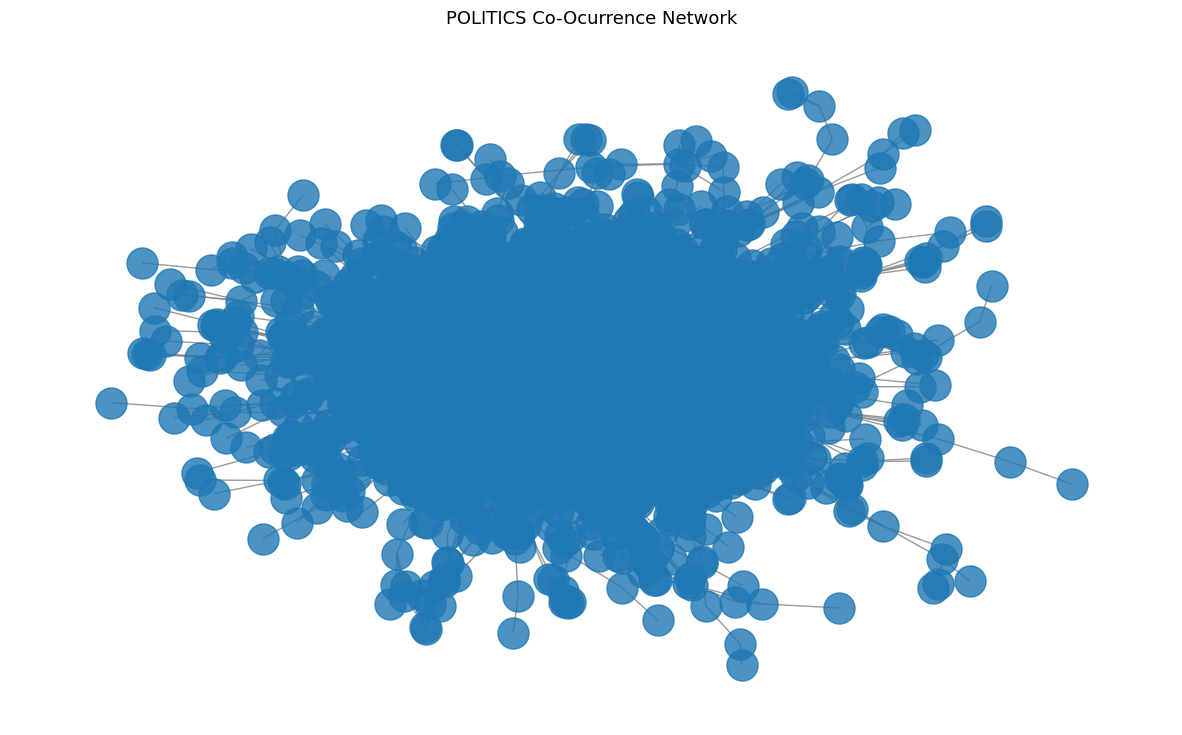

In [17]:
category_networks["POLITICS"]["nxPlot"]

In [18]:
arts_metadata = compute_metrics(category_networks["POLITICS"]["nxGraph"],10, f" Politics Category")
display_html(arts_metadata["metrics_view"], raw=True)

Politics Category Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.366529 
 
 
 Weighted Average Clustering 
 0.004127 
 
 
 Density 
 0.000920 
 
 
 

 
 
 Degree Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 congressman 
 0.020959 
 0.430299 
 
 
 1 
 bernie 
 0.020959 
 0.430299 
 
 
 2 
 sen 
 0.014917 
 0.306249 
 
 
 3 
 isis 
 0.014728 
 0.302372 
 
 
 4 
 obamacare 
 0.014539 
 0.298496 
 
 
 5 
 putin 
 0.014162 
 0.290743 
 
 
 6 
 rubio 
 0.014162 
 0.290743 
 
 
 7 
 cia 
 0.013973 
 0.286866 
 
 
 8 
 syria 
 0.013595 
 0.279113 
 
 
 9 
 comey 
 0.013218 
 0.271360 
 
 
 
 
 
 Betweenness Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 congressman 
 0.085596 
 2.092043 
 
 
 1 
 sen 
 0.060704 
 1.483651 
 
 
 2 
 bernie 
 0.060315 
 1.474165 
 
 
 3 
 obamacare 
 0.045907 
 1.122017 
 
 
 4 
 syria 
 0.042638 
 1.042121 
 
 
 5 
 mcconnell 
 0.038928 
 0.951447 
 
 
 6 
 comey 
 0.038455 
 0.939880 
 
 
 7 
 isis 
 0.035641 
 0.871106 
 
 
 8 
 cia 
 0.033472 
 0.818091 
 
 
 9 
 rubio 
 0.032012 
 0.782399 
 
 
 
 
 
 Eigenvector Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 congressman 
 0.214181 
 0.700111 
 
 
 1 
 bernie 
 0.205764 
 0.672597 
 
 
 2 
 rubio 
 0.197024 
 0.644027 
 
 
 3 
 mcconnell 
 0.188052 
 0.614699 
 
 
 4 
 sen 
 0.184844 
 0.604213 
 
 
 5 
 mitch 
 0.170812 
 0.558345 
 
 
 6 
 obamacare 
 0.165759 
 0.541829 
 
 
 7 
 marco 
 0.153440 
 0.501559 
 
 
 8 
 caucus 
 0.144190 
 0.471326 
 
 
 9 
 comey 
 0.125337 
 0.409698

The **Politics** co-occurrence network is very sparse, meaning that only a small number of word pairs appear together. The low density shows that political terms do not consistently co-occur in fixed patterns. Compared to Arts & Culture, the clustering is lower, suggesting that political language is less locally grouped. The extremely low weighted clustering indicates that most connections between words are weak and do not appear repeatedly.

Degree centrality shows that the network is centered around **political figures and official roles**. Words such as **congressman** and **sen** represent elected officials, while names like **Bernie** (Bernie Sanders, U.S. Senator), **Rubio** (Marco Rubio, U.S. Senator), **McConnell** (Mitch McConnell, U.S. Senate leader), and **Putin** (Vladimir Putin, President of Russia) refer to prominent political leaders frequently mentioned in news coverage. Policy- and event-related terms such as **Obamacare** (U.S. healthcare legislation), **ISIS** (a militant extremist group), and **Syria** (a country central to ongoing conflict and foreign policy debates) also rank highly, reflecting the range of topics covered in political reporting.

Betweenness centrality highlights terms that connect different parts of political discourse. **Congressman** and **sen** link discussions about individual politicians with broader legislative debates, while terms such as **Syria**, **CIA** (U.S. intelligence agency), and **ISIS** connect domestic politics with foreign policy and national security topics. Eigenvector centrality reinforces this pattern, with well-known political figures and institutions appearing as the most influential nodes. Overall, the Politics network is shaped largely by references to people, offices, and major political issues rather than tightly connected thematic clusters.


In [19]:
pol_cliques,pol_cliques_styled =  compute_cliques(category_networks["POLITICS"]["nxGraph"])
pol_cliques_styled

Size,Members
10,"banish, enlightened, insidious, marie, masquerade, misogyny, rehearse, sexist, vocabulary, zeal"
9,"breakup, containment, foreseeable, instability, overthrow, precipice, saddam, sunni, tribal"
9,"angrily, chew, communist, fascist, memorandum, remnant, saliva, saturate, socialist"
8,"aol, emmys, ion, lithium, macy, nordstrom, univision, verizon"
8,"adolf, ascent, dictator, enrique, hitler, liken, nieto, peña"


The cliques identified in the **Politics** network reflect small groups of words that tend to appear together in very specific political contexts. Several cliques are driven by **political rhetoric and ideology**, grouping words such as *communist*, *fascist*, *socialist*, and emotionally charged terms like *angrily* and *insidious*. Other cliques focus on **conflict and instability**, combining words related to geopolitics and power struggles, such as *Saddam* (Saddam Hussein, former Iraqi president), *Sunni*, *tribal*, and *overthrow*. These clusters reflect language commonly used in discussions of war, regime change, and international instability.

The other cliques are centered on **historical and contemporary political figures**, including *Hitler* (Adolf Hitler, Nazi leader) and *Peña Nieto* (Enrique Peña Nieto, former President of Mexico), often grouped with terms describing dictatorship or political ascent. One clique stands out as being more **media- and corporate-focused**, combining names such as *AOL*, *Verizon*, *Univision*, and major retail brands, suggesting discussions where politics intersects with media, business, or regulation. Taken together, these cliques represent all of the densely connected subgroups in the Politics network and highlight how political language clusters around ideology, conflict, leadership, and institutional power rather than forming a single cohesive structure.


### 3.2 Science & Tech

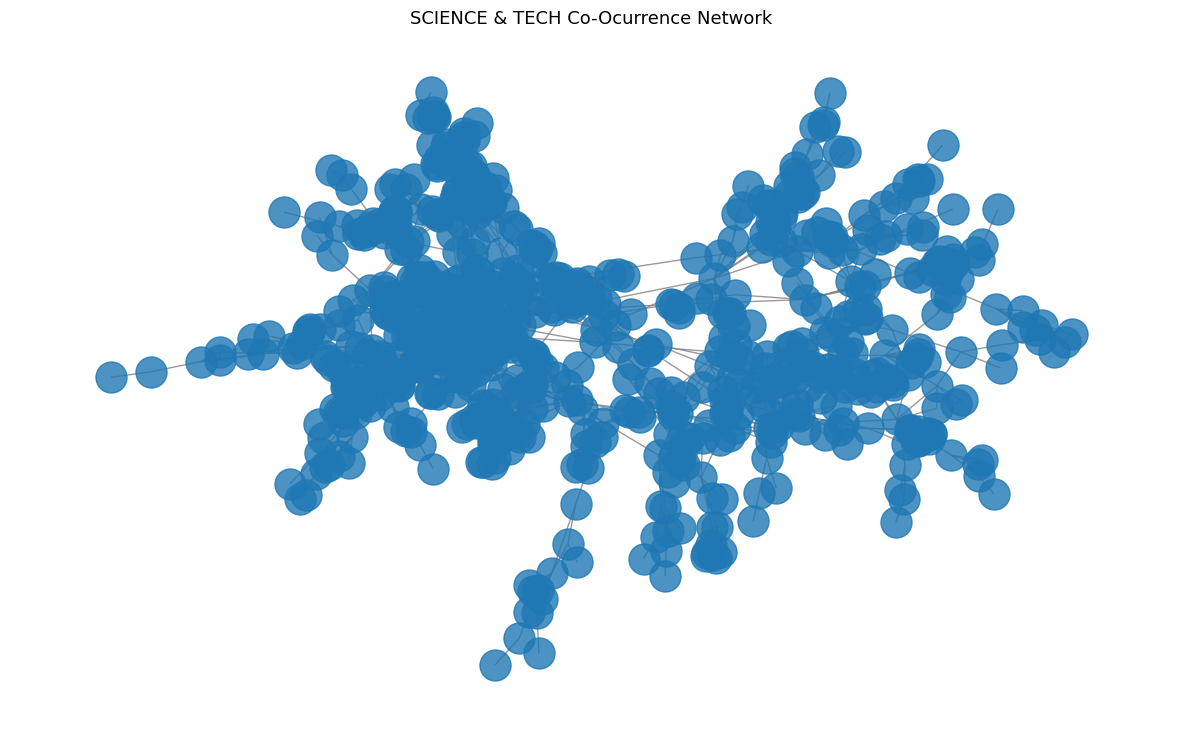

In [20]:
category_networks["SCIENCE & TECH"]["nxPlot"]

In [21]:
arts_metadata = compute_metrics(category_networks["SCIENCE & TECH"]["nxGraph"],10, f" Science & Tech Category Metrics")
display_html(arts_metadata["metrics_view"], raw=True)

Science & Tech Category Metrics Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.479180 
 
 
 Weighted Average Clustering 
 0.062984 
 
 
 Density 
 0.004877 
 
 
 

 
 
 Degree Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 particle 
 0.039244 
 1.167820 
 
 
 1 
 orbit 
 0.031977 
 0.951557 
 
 
 2 
 spacecraft 
 0.030523 
 0.908304 
 
 
 3 
 telescope 
 0.029070 
 0.865052 
 
 
 4 
 physicist 
 0.027616 
 0.821799 
 
 
 5 
 astronomer 
 0.024709 
 0.735294 
 
 
 6 
 hacker 
 0.024709 
 0.735294 
 
 
 7 
 protein 
 0.023256 
 0.692042 
 
 
 8 
 psychiatric 
 0.021802 
 0.648789 
 
 
 9 
 rover 
 0.020349 
 0.605536 
 
 
 
 
 
 Betweenness Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 orbit 
 0.167798 
 2.877903 
 
 
 1 
 physics 
 0.163457 
 2.803446 
 
 
 2 
 spacecraft 
 0.162852 
 2.793063 
 
 
 3 
 physicist 
 0.141357 
 2.424404 
 
 
 4 
 astronomer 
 0.125391 
 2.150570 
 
 
 5 
 interstellar 
 0.119404 
 2.047891 
 
 
 6 
 particle 
 0.115066 
 1.973485 
 
 
 7 
 invention 
 0.114409 
 1.962224 
 
 
 8 
 saturn 
 0.104119 
 1.785746 
 
 
 9 
 hacker 
 0.097900 
 1.679086 
 
 
 
 
 
 Eigenvector Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 particle 
 0.441468 
 5.853362 
 
 
 1 
 protein 
 0.299671 
 3.973287 
 
 
 2 
 accelerator 
 0.258774 
 3.431039 
 
 
 3 
 physics 
 0.249432 
 3.307178 
 
 
 4 
 experimental 
 0.244407 
 3.240555 
 
 
 5 
 physicist 
 0.238118 
 3.157174 
 
 
 6 
 atom 
 0.237788 
 3.152794 
 
 
 7 
 applied 
 0.205157 
 2.720139 
 
 
 8 
 sesame 
 0.205157 
 2.720139 
 
 
 9 
 sprout 
 0.146056 
 1.936530

The **Science & Tech** co-occurrence network shows a moderate level of connectivity and clear local structure. The density is higher than what is typically seen in very sparse networks, indicating that scientific and technical terms tend to appear together more often. The average clustering suggests that related concepts form small, well-connected groups, while the weighted clustering indicates that several of these connections are repeated rather than incidental.

Degree centrality highlights **core scientific concepts and technical domains**. Terms such as **particle**, **orbit**, **spacecraft**, and **telescope** are among the most connected nodes, reflecting a strong presence of physics and space-related topics. Professional roles like **physicist** and **astronomer** also appear prominently, alongside terms from biology and applied science such as **protein**, **psychiatric**, and **fossil**, suggesting a broad range of scientific discussion within the category.

Betweenness centrality identifies words that link different scientific areas. Terms such as **orbit**, **physics**, and **spacecraft** connect discussions of theory, experimentation, and space exploration. Eigenvector centrality emphasizes foundational concepts, with **particle**, **protein**, and **physics** ranking highest, indicating that influence in the network is driven by widely referenced scientific ideas rather than specific individuals. Overall, the Science & Tech network is structured around shared concepts and terminology that connect multiple scientific fields.


In [22]:
tech_cliques,tech_cliques_styled =  compute_cliques(category_networks["SCIENCE & TECH"]["nxGraph"])
tech_cliques_styled

Size,Members
7,"clump, electron, microscopic, molecule, oxygen, protein, splitting"
7,"accelerator, applied, experimental, particle, physics, protein, sesame"
6,"carcinogen, confer, institutional, mineral, presumption, radiation"
6,"archaeologist, cosmo, invention, retrieve, techno, wondrous"
6,"constitutional, distortion, inappropriately, psychiatric, railroad, slippery"


The cliques identified in the **Science & Tech** network represent small groups of words that consistently appear together in specific scientific or technical contexts. 

Several cliques are centered on **core scientific concepts**, particularly in physics and biology. Groups containing terms such as *particle*, *electron*, *atom*, *molecule*, and *protein* suggest discussions related to fundamental scientific processes and experimental research. These cliques emphasize the role of shared terminology in connecting different areas of scientific inquiry.

Other cliques capture more **applied or interdisciplinary contexts**, combining words like *accelerator*, *experimental*, *applied*, and *physics*, as well as terms related to technology and innovation such as *techno* and *invention*. A few cliques also include language associated with **health and behavioral science**, such as *psychiatric*, indicating that the category spans multiple domains beyond the physical sciences. Taken together, these cliques represent all densely connected subgroups in the Science & Tech network and illustrate how the category is organized around compact, concept-driven clusters rather than a single unified structure.


### 3.4 Network Structure Across Remaining Categories (Metrics Only)

In addition to the three categories analyzed in detail, the remaining categories in the dataset are examined at a higher level. Instead of interpreting each category individually, this section presents summary tables of key network metrics. These tables make it easier to compare categories and identify broader structural differences without repeating similar explanations.


In [ ]:
other_cats = [cat for cat in news_df["category_merged"].unique() if cat not in ["SCIENCE & TECH","POLITICS","ARTS & CULTURE"] ]
for cat in other_cats:
    print(cat)
    arts_metadata = compute_metrics(category_networks[cat]["nxGraph"],10, f" Metrics")
    display_html(arts_metadata["metrics_view"], raw=True)
    cliques,cliques_styled =  compute_cliques(category_networks[cat]["nxGraph"])
    display_html(cliques_styled.to_html, raw=True)

U.S. NEWS


Metrics Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.464071 
 
 
 Weighted Average Clustering 
 0.243696 
 
 
 Density 
 0.082540 
 
 
 

 
 
 Degree Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 fatally 
 0.314286 
 10.576923 
 
 
 1 
 robb 
 0.257143 
 8.653846 
 
 
 2 
 gutierrez 
 0.171429 
 5.769231 
 
 
 3 
 botched 
 0.142857 
 4.807692 
 
 
 4 
 gunman 
 0.114286 
 3.846154 
 
 
 5 
 eva 
 0.114286 
 3.846154 
 
 
 6 
 lapd 
 0.114286 
 3.846154 
 
 
 7 
 cinematographer 
 0.114286 
 3.846154 
 
 
 8 
 swastika 
 0.085714 
 2.884615 
 
 
 9 
 slur 
 0.085714 
 2.884615 
 
 
 
 
 
 Betweenness Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 fatally 
 0.710924 
 28.427419 
 
 
 1 
 robb 
 0.529412 
 21.169355 
 
 
 2 
 eva 
 0.208403 
 8.333333 
 
 
 3 
 lapd 
 0.164706 
 6.586022 
 
 
 4 
 gutierrez 
 0.161345 
 6.451613 
 
 
 5 
 swastika 
 0.161345 
 6.451613 
 
 
 6 
 botched 
 0.112605 
 4.502688 
 
 
 7 
 gunman 
 0.112605 
 4.502688 
 
 
 8 
 jerome 
 0.110924 
 4.435484 
 
 
 9 
 adams 
 0.057143 
 2.284946 
 
 
 
 
 
 Eigenvector Centrality (Top 10 Nodes) 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 fatally 
 0.512202 
 11.525990 
 
 
 1 
 robb 
 0.396011 
 8.911368 
 
 
 2 
 botched 
 0.277668 
 6.248311 
 
 
 3 
 gutierrez 
 0.275624 
 6.202320 
 
 
 4 
 condemnation 
 0.256333 
 5.768211 
 
 
 5 
 cinematographer 
 0.228445 
 5.140659 
 
 
 6 
 baldwin 
 0.219669 
 4.943169 
 
 
 7 
 eva 
 0.160495 
 3.611595 
 
 
 8 
 ruiz 
 0.153464 
 3.453385 
 
 
 9 
 ruben 
 0.153464 
 3.453385

ValueError: Can't clean for JSON: <pandas.io.formats.style.Styler object at 0x7ab4ad56ad20>

## 4. Model Development

As part of the model development phase, several supervised learning models are trained and compared, including **Logistic Regression**, **Support Vector Machines (SVM)**, **Random Forests**, and a transformer-based **DistilBERT** model. To support the traditional machine learning models, Word2Vec is used to generate dense document-level embeddings that serve as input features, allowing a direct comparison between embedding-based classifiers and transformer-based approaches.

- Each document in the training and test sets is tokenized into individual words using whitespace splitting.
- A Word2Vec model is trained on the **training data only** to learn word-level embeddings and avoid information leakage.
- The skip-gram architecture is used to capture semantic relationships between words, with each word represented by a 128-dimensional vector.
- Words appearing fewer than two times in the corpus are excluded to reduce noise.
- Document-level embeddings are created by averaging the vectors of all in-vocabulary words within each document.
- Documents with no valid tokens are assigned a zero vector to maintain consistent dimensionality.
- The resulting document embeddings are used as inputs to **Logistic Regression**, **SVM**, and **Random Forest** classifiers.




In [24]:
subset_size =  0.8
target_field = "category_merged"

x_train,x_test, y_train,y_test = train_test_split(
    news_df["clean_text"],
    news_df[target_field],
    train_size=0.8,
    test_size=0.2, 
    random_state=456,
    stratify=news_df[target_field]
    )

In [25]:
x_train_tokens = [text.split() for text in x_train]
x_test_tokens  = [text.split() for text in x_test]

w2v_model = Word2Vec(
    sentences=x_train_tokens,
    vector_size=128,
    window=10,
    min_count=2,
    workers=2,
    sg=1
)

def document_vector(words):
    words = [w for w in words if w in w2v_model.wv]
    if len(words) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[words], axis=0)

v_train_set = np.vstack([document_vector(words) for words in x_train_tokens])
v_test_set  = np.vstack([document_vector(words) for words in x_test_tokens])

In [26]:
cv_param = 2
njobs = 5


### 4.1 SVM

The Support Vector Machine model was tuned using a Grid Search focused on the regularization parameter **C**, tested from **0.001 to 1** in increments of **0.009**. This parameter controls the trade-off between fitting the training data well and maintaining good generalization on unseen data.


In [27]:

v_train_scaled = normalize(v_train_set)
v_test_scaled  = normalize(v_test_set)
# svm_param_grid = {'C': np.arange(0.05, 1, 0.1)}
svm_param_grid = {'C': [0.95]}

svm_model = LinearSVC(random_state=500,    max_iter=1000)

grid = GridSearchCV(svm_model, svm_param_grid, cv=cv_param, scoring='accuracy', n_jobs=njobs, verbose=0)
grid.fit(v_train_scaled, y_train)
svm_model = grid.best_estimator_

svm_df, svm_df_styled = generate_report(svm_model,v_train_scaled,y_train,v_test_scaled,y_test,average="weighted")


### 4.2 Logistic Regression

For Logistic Regression, a Grid Search explored **C** values from **0.001 to 1** in increments of **0.005**, along with two solver options: **liblinear** and **lbfgs**. These settings helped identify the best regularization strength and optimization approach for handling text-based sentiment data efficiently.


In [28]:
log_reg = LogisticRegression(max_iter=1000,random_state=452)

# log_param_grid = {'C': np.arange(0.001, 5, 0.005), 'solver': ['lbfgs']}
# Best C
log_param_grid = {'C': [1.47], 'solver': ['lbfgs']}


grid = GridSearchCV(estimator=log_reg, param_grid=log_param_grid,cv=cv_param, scoring='accuracy', n_jobs=njobs, verbose=0)

grid.fit(v_train_set, y_train)

logistic_model = grid.best_estimator_

lgreg_df, lgreg_df_styled = generate_report(logistic_model,v_train_set,y_train,v_test_set,y_test,average="weighted")


### 4.3 Random Forest

The Random Forest model was trained using a parameter grid that aimed to balance accuracy and generalization. The **n_estimators** values (**200** and **400**) controlled the number of trees, while **max_depth** (**None** and **20**) adjusted tree growth to manage complexity. The **max_features** parameter was set to **"sqrt"** to reduce feature correlation and improve model diversity.

The grid also tuned **min_samples_split** (**2**, **5**) and **min_samples_leaf** (**1**, **2**) to control how many samples were needed to create or end splits in each tree. These settings helped identify the best configuration for stable and efficient model performance.


In [29]:
random_forest = RandomForestClassifier(random_state=500)

rf_param_grid = param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 20],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}


grid = GridSearchCV(estimator=random_forest, param_grid=rf_param_grid,cv=cv_param, scoring='accuracy', n_jobs=njobs, verbose=0)

grid.fit(v_train_set, y_train)


random_forest = grid.best_estimator_


/home/lewris/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [30]:
random_forest_df, random_forest_df_styled = generate_report(random_forest,v_train_set,y_train,v_test_set,y_test,average="weighted")


### 3.4 DistilBERT

DistilBERT, As a distilled transformer architecture derived from BERT, is used due to its ability for retaining strong contextual representation capabilities while reducing computational complexity. Through self-attention, the model captures semantic and long-range dependencies across entire text sequences, making it well suited for context-dependent classification tasks. Following section summarizes the dataset preparation, model configuration, and training procedure used in this project.

- **Dataset Preparation and Formatting**  
  The training and test datasets are constructed by pairing text inputs with their corresponding labels, encoding the labels into numeric form, converting the data into Hugging Face Dataset objects, and formatting them as PyTorch tensors to support transformer-based training.

- **Tokenization**  
  Text is tokenized using the DistilBERT tokenizer, with padding and truncation applied to a fixed maximum length of 128 tokens to ensure consistent input sizes. Tokenization is performed in batches, after which the original text column is removed so that only the tokenized inputs and labels are passed to the model.

- **Model Architecture**  
  The **distilbert-base-uncased** model is used with a sequence classification head added on top of the pretrained encoder. The output layer is configured to match the number of target classes, allowing the model to learn task-specific decision boundaries while leveraging pretrained language representations.

- **Training Configuration and Process**  
  Training is conducted using Hugging Face’s **Trainer** API. While multiple hyperparameter combinations were explored during experimentation, the code reflects **only the final selected configuration**. The model is trained for **10 epochs** using a **batch size of 180** and a **learning rate of 3 × 10⁻⁶**, with evaluation performed at the end of each epoch and the best-performing model retained automatically.


In [31]:
training_device  = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
le =  LabelEncoder()
bert_train = pd.DataFrame({"text": x_train, "labels": y_train}).reset_index(drop=True)
bert_test  = pd.DataFrame({"text": x_test, "labels": y_test}).reset_index(drop=True)
bert_train["labels"] = le.fit_transform(bert_train["labels"])
bert_test["labels"] = le.transform(bert_test["labels"])

num_labels = len(le.classes_)
hf_train_raw = Dataset.from_pandas(bert_train)
hf_test_raw  = Dataset.from_pandas(bert_test)

y_train_enc = bert_train["labels"].values

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)

# bert_class_weights = torch.tensor(class_weights, dtype=torch.float)

In [33]:
# classifier = "roberta-base"
classifier = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(classifier)
# tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# 
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenize datasets
bert_train_dataset = hf_train_raw.map(tokenize, batched=True, batch_size=1024)
bert_test_dataset  = hf_test_raw.map(tokenize, batched=True, batch_size=1024)

# Remove text column (BERT uses tokenized fields only)
bert_train_dataset = bert_train_dataset.remove_columns(["text"])
bert_test_dataset  = bert_test_dataset.remove_columns(["text"])

# Set dataset format for PyTorch
bert_train_dataset.set_format("torch")
bert_test_dataset.set_format("torch")


bert_model = DistilBertForSequenceClassification.from_pretrained(
   classifier,
    num_labels=num_labels,
     ignore_mismatched_sizes=True
).to(training_device)

# bert_model = RobertaForSequenceClassification.from_pretrained(
#    classifier,
#     num_labels=num_labels,
#      ignore_mismatched_sizes=True
# ).to(training_device)

Map: 100%|██████████| 41906/41906 [00:02<00:00, 14323.46 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Best params
batch_size = 180
bert_learning_rate = 3e-6
# epoch_n = 15
epoch_n = 10


In [35]:
bert_training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=bert_learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch_n,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
      dataloader_num_workers=4,  # try 4–8
    dataloader_pin_memory=True,
      fp16=True
)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset
    # tokenizer = tokenizer
)

# bert_trainer = WeightedLossTrainer(
#     model=bert_model,
#     args=bert_training_args,
#     train_dataset=bert_train_dataset,
#     eval_dataset=bert_test_dataset,
#     class_weights=bert_class_weights
# )

bert_trainer.train()
# eval_metrics = bert_trainer.evaluate()


Epoch,Training Loss,Validation Loss
1,1.399600,1.314833
2,1.095400,1.115206
3,1.007900,1.040789
4,0.992100,1.003613
5,0.985900,0.980456
6,0.980600,0.967445
7,0.926100,0.957196
8,0.878600,0.950372
9,0.859500,0.947824
10,0.870100,0.946556


TrainOutput(global_step=9320, training_loss=1.0701875235389742, metrics={'train_runtime': 2842.1051, 'train_samples_per_second': 589.778, 'train_steps_per_second': 3.279, 'total_flos': 5.552663387475456e+16, 'train_loss': 1.0701875235389742, 'epoch': 10.0})

In [36]:
train_predict_output = bert_trainer.predict(bert_train_dataset)
test_predict_output = bert_trainer.predict(bert_test_dataset)

In [37]:
# y_pred_train = np.argmax(train_predict_output.predictions, axis=1)
# y_true_train = train_predict_output.label_ids

# y_pred_test = np.argmax(test_predict_output.predictions, axis=1)
# y_true_test = test_predict_output.label_ids$70.00
y_pred_train = np.argmax(train_predict_output.predictions, axis=1)
y_true_train = bert_train_dataset["labels"]

y_pred_test = np.argmax(test_predict_output.predictions, axis=1)
y_true_test = bert_test_dataset["labels"]


# bert_train_metrics = evaluate_model(y_true_train,y_pred_train,"weighted")
# bert_test_metrics = evaluate_model(y_true_test,y_pred_test,"weighted")

bert_train_metrics = evaluate_model(y_true_train,y_pred_train,"weighted")
bert_test_metrics = evaluate_model(y_true_test,y_pred_test,"weighted")
bert_train_metrics["Set"] = "Training"
bert_test_metrics["Set"] = "Test"


bert_model_metrics_df = pd.DataFrame(columns=model_metrics,data= [bert_train_metrics,bert_test_metrics])
bert_styled_report = bert_model_metrics_df.style.hide(axis="index")


/home/lewris/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lewris/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 5. Model Evaluation and Recommendation

In [38]:
svm_df["Model"] = "SVM"
random_forest_df["Model"] = "Random Forest"
lgreg_df["Model"] = "Logistic Regression"
bert_model_metrics_df["Model"] = "DistilBERT"

combined_df = pd.concat([svm_df, random_forest_df, lgreg_df, bert_model_metrics_df], ignore_index=True)
cols = ["Model"] + [col for col in combined_df.columns if col != "Model"]
combined_df = combined_df[cols]
training_summary = combined_df[combined_df["Set"] == "Training"].style.hide(axis="index")
test_summary = combined_df[combined_df["Set"] == "Test"].style.hide(axis="index")


final_result_sum = display_side_by_side([training_summary,test_summary],["Training Evaluation","Test Set Evaluation"])


In [39]:
display_html(final_result_sum,raw=True)

Model,Set,Accuracy,Precision,Recall,Sensitivity,Specificity,F1
SVM,Training,0.639705,0.627984,0.639705,0.956640,0.993469,0.623718
Random Forest,Training,0.999714,0.999714,0.999714,1.000000,1.000000,0.999714
Logistic Regression,Training,0.644472,0.634738,0.644472,0.976721,0.990457,0.635386
DistilBERT,Training,0.737748,0.730525,0.737748,0.992041,0.994852,0.732515
Model,Set,Accuracy,Precision,Recall,Sensitivity,Specificity,F1
SVM,Test,0.635828,0.623996,0.635828,0.956522,0.997067,0.619663
Random Forest,Test,0.628884,0.641126,0.628884,0.937984,0.995208,0.605975
Logistic Regression,Test,0.638214,0.628710,0.638214,0.970711,0.992032,0.628619
DistilBERT,Test,0.709087,0.701871,0.709087,0.992556,0.996736,0.704133


Examining both the training and test results provides a clear view of how each model fits the data and how well it generalizes. The **Random Forest** model achieves near-perfect performance on the training set across all metrics, indicating that it learns the training data extremely well. However, this strong training performance does not translate to the test set, where both accuracy and F1 score decline. The gap between training and test results suggests that the model is overfitting and struggling to generalize beyond the data it was trained on.

The **BERT** model demonstrates strong and consistent performance across both datasets. During training, it achieves high accuracy with well-balanced precision, recall, and F1 scores, and these results remain largely stable when evaluated on the test set. BERT also maintains very high sensitivity and specificity, indicating that it effectively identifies both positive and negative cases. Unlike the Random Forest, BERT shows minimal performance degradation when moving from training to test data, which points to better generalization.

The **Logistic Regression** and **SVM** models display similar patterns in both training and test evaluations. Their accuracy remains in the mid-0.60 range, with consistently high sensitivity and specificity. While this indicates reliable baseline performance, their lower precision and F1 scores suggest that these models have limited capacity to capture more complex relationships in the data, which likely constrains their overall effectiveness.

Taken together, the evaluation metrics clearly indicate that **BERT is the strongest model in this comparison**. It achieves the highest accuracy and F1 score on the test set while maintaining a balanced trade-off between precision and recall. Its consistent performance across training and test results suggests that it learns meaningful patterns rather than memorizing the data, making it the most reliable and effective model based on the metrics observed.


## 6. Conclusion

This project demonstrated the effectiveness of combining **Word2Vec embeddings** with traditional machine learning algorithms for sentiment classification on the IMDB movie review dataset. Through systematic data cleaning, feature extraction, and model evaluation, it became clear that the quality of text representation played the most significant role in achieving strong model performance. The Word2Vec model captured meaningful semantic relationships between words, allowing classifiers to interpret sentiment and context more effectively.

Among the four models tested, **SVM**, **Logistic Regression**, **Random Forest**, and **XGBoost**, the **SVM** achieved the best balance between accuracy and generalization, while Logistic Regression and XGBoost produced similar, consistent results. The Random Forest model achieved near-perfect accuracy during training but showed clear signs of overfitting when evaluated on unseen data.

Overall, the findings highlight that **feature quality is more important than model complexity** in text classification tasks. The Word2Vec embeddings provided a solid foundation for sentiment understanding, enabling even simple models to perform well. Future work could involve fine-tuning embedding parameters, using pre-trained Word2Vec or Transformer-based models, and extending this framework to more diverse or multi-class datasets to further improve generalization and interpretability.
